
#### Notebook 1 - Training using labelled data 

In this data analysis challenge, we are interested in developing an automatic sentiment classification system that relies on machine learning techniques to learn from a large set of product reviews provided by Yelp. The levels of polarity of opinion we consider include strong negative, weak negative, neutral, weak positive, and strong positive

The aim of this challenge is to develop a sentiment classifier that can assign a large set of product reviews to the five levels of polarity of opinion as accurately as possible, given a small amount of labeled reviews and a large amount of unlabelled reviews.



In this notebook,transfer learning in Natural Language Processing is implemented using the FastAI library.
The Universal Language Fine-tuning for Text Classification paper is applied to classify the sentiment of Yelp reviews as a 5 star rating. 
This method helps to achieve relatively good results with not a huge sample of training data
The labelled dataset used is 50K samples Yelp reviews

To achieve comptutaional backend **Google Colab** was used to implement codes and some of the codes would be specific for implementation in Colab

In [3]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Section1 - Loading the libraries

In [0]:
import numpy as np
import pandas as pd
from fastai import *
from fastai.text import *
from fastai.vision import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

### Section 2 - Reading and Exploring the data

In [3]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/labeled_data.csv')
data.head(3)

,text,label
0,The new rule is - \r\nif you are waiting for a...,4
1,"Flirted with giving this two stars, but that's...",3
2,I was staying at planet Hollywood across the s...,5


In [4]:
df_train, df_test = train_test_split(data[['label', 'text']], test_size=0.2)
df_train = df_train.dropna()
df_test = df_test.dropna()
df_test.head()

,label,text
41760,4,Love these guys! I have a huge picnic every ye...
5854,5,"Like the other reviewers said, this place is d..."
44345,3,"Our first experience here was terrible, but th..."
48733,2,The chicken Asada burrito is really good. I wi...
43920,4,The food at Golden Dragon is awfully good. The...


In fastai library, the data processing can be done using the from_df method of the TextLMDataBunch. 
The different steps of preprocessing such as: cleaning, tokenizing, indexing, building vocabulary, etc. are done using this module.

The source code of the pre processing steps can be found at 
https://github.com/fastai/fastai/blob/master/fastai/text/transform.py
    

text.tranform contains the functions that deal behind the scenes with the two main tasks when preparing texts for modelling: tokenization and numericalization.

Tokenization splits the raw texts into tokens (which can be words, or punctuation signs...). The most basic way to do this would be to separate according to spaces, but it's possible to be more subtle; for instance, the contractions like "isn't" or "don't" should be split in ["is","n't"] or ["do","n't"]. By default fastai will use the powerful spacy tokenizer.

Numericalization is easier as it just consists in attributing a unique id to each token and mapping each of those tokens to their respective ids.

Ref https://docs.fast.ai/text.transform.html

Tokenization step is actually divided in two phases: first, a certain list of rules to the raw texts is applied as preprocessing, then we use the tokenizer to split them in lists of tokens. Combining together those rules, the tok_funcand the lang to process the texts is the role of the Tokenizer class.



This preprocessing is for the language model

In [0]:
data_lm = TextLMDataBunch.from_df('./', df_train, df_test)

UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)

PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch

BOS (xxbos) represents the beginning of a text in your dataset

FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)

TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text

TK_UP (xxup) is used to indicate the next word is written in all caps in the original text

TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})

TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

In [7]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'the',
 ',',
 'and',
 'i',
 'to',
 'a',
 'was',
 'it',
 'of',
 'for']

### Section 3 - NLP model creation and training and fine tuning
The main thing here is RNNLearner. There are also some utility functions to help create and update text models.

Ref: https://docs.fast.ai/text.learner.html#language_model_learner

The achitecture used is AWD_LSTM as proposed in the ULMFiT paper using a pretrained model. the drop_mult is applied to all the dropouts weights of the config as per various architecture. drop_mult=0.5 as per the documentation for AWD_LSTM


In [0]:
learn = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, drop_mult=0.5)

The language model can be tested for a word to see if the sentense formed is reasonable for a given word

In [9]:
#testing for the word 'what'
learn.predict('What', 100)

'What TV series follows is a campaign of TV and resolution stories about the history of American politics and political politics . The history of the Heartbreaking headaches have been cultural exhibits in the history of the United States . Officially , they are described as being valuable issues and desired as a literal interpretation of their characters . Art is based on the appearance of historical figures , which involved wealthy citizen newspapers and films by authors and artists such as - before Building God . About 1000'

lr_find helps to fing a learning rate over iterations
Explores from start_lr(1e-07) to end_lr(10) over num_it iterations(100) in learn, stops when loss diverges.

Ref https://docs.fast.ai/basic_train.html#lr_find
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


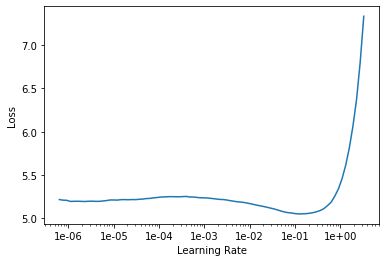

In [10]:
learn.lr_find()
learn.recorder.plot()

Firstly only the last softmax layer is fitted as per ULMFiT paper.
fit_one_cycle fits a model following the 1cycle policy.

Ref https://docs.fast.ai/basic_train.html#fit_one_cycle

In [11]:
#last softmax layer fitted
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.081758,3.363927,0.257143,11:33


In [12]:
# Then unfreeze the model and fit it again
learn.unfreeze()
#learn.fit_one_cycle(10, 1e-2)
learn.fit_one_cycle(7, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.784193,3.219397,0.300000,13:40
1,3.666838,3.146044,0.357143,13:35
2,3.576536,3.092621,0.385714,13:39
3,3.468062,3.058227,0.385714,13:38
4,3.356156,3.058938,0.400000,13:39
5,3.258097,3.010541,0.400000,13:40
6,3.210307,3.014720,0.400000,13:42


The above results can be interpretted as the model can predict the next word with an accuracy of 0.40 


In [13]:
# testing the predicting capability of the model
print(learn.predict('xxbos', n_words=100))

xxbos i am grass fed . i get their support from every local business . This has been my favorite " Market Road " of Jewish deli as P.S. The place is used to gun visitors , but still , it has made me sick to my wallet . You can enjoy the Spuds for sure ! ! ! xxbos i can not stand how reading the reviews is .... iiii 'm'm'm'm throwingthrowingthrowingthrowing upupupup !!!! forforforfor pickedpickedpickedpicked upupupup mymymymy carcarcarcar thisthisthisthis morningmorningmorningmorning !!!! Best falafel i 've had in years


We can see the language model now predicts with context to the Yelp dataset as opposed to generic corpus

We can save the encoder as fine_enc for later use

In [0]:
# Save the encoder
learn.save_encoder('fine_enc')

#### Now preprocessing for the classifier model

In [0]:
# Preprocess data
data_clas = TextClasDataBunch.from_df('./', df_train, df_test, vocab=data_lm.vocab, bs=32)

In [17]:
# Building a classifier with the same architechure and weights as the language model trained above
classifier = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (40000 items)
x: TextList
xxbos xxmaj update xxmaj review : xxmaj tako has completely redone their menu . xxmaj your old favorites are completely different . xxmaj they do have some new tacos which are fun , i 'd recommend the duck taco . 
 
  xxmaj however , they redid the xxmaj tako taco- it is terrible ! ! ! xxmaj extremely fishy and now deep fried . i have no idea why they would change their menu , especially when it was working . i think the new menu has had an impact on their business because the place was not nearly as busy with many empty seats . xxmaj you might not need a reservation anymore . xxmaj save yourself the heart ache , eat something at home . xxmaj that 's what we 'll be doing next time !,xxbos xxmaj had the calzone with xxunk cheese , spinach , xxmaj alfredo sauce , jalapeã±os , and onions . xxmaj amazing taste . xxmaj definitely recommend all vegetarians to order this next time .,xxbos xxmaj there 's a small spa

lr_find helps to fing a learning rate over iterations
Explores from start_lr(1e-07) to end_lr(10) over num_it iterations(100) in learn, stops when loss diverges.

Ref https://docs.fast.ai/basic_train.html#lr_find

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


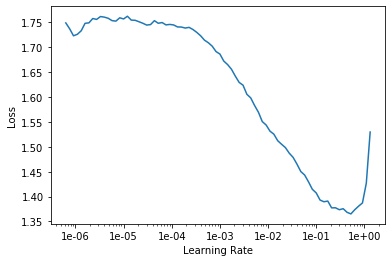

In [18]:
classifier.lr_find()
classifier.recorder.plot()

Fitting one cycle with momentum which often improves both training speed and accuracy.

In [19]:
classifier.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.959569,0.879461,0.620000,06:28


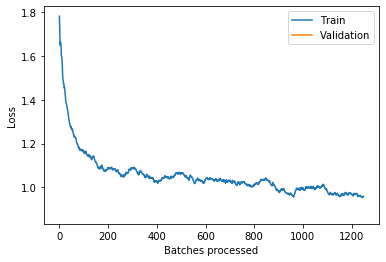

In [20]:
classifier.recorder.plot_losses()

In the below steps the same steps are performed again with the aim of improving accuracy as per the hyperparameter tuning techinques suggested in the ULMFit paper. 
This includes
1. Dicriminative learning rate
2. One cycle learning
3. Gradual unfreezing

The details can be found at 
https://arxiv.org/pdf/1801.06146.pdf



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


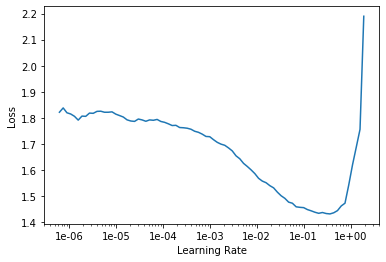

In [21]:
classifier = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')
classifier.lr_find()
classifier.recorder.plot()

In [22]:
classifier.fit_one_cycle(1, slice(1e-4, 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.987827,0.873091,0.623600,06:31


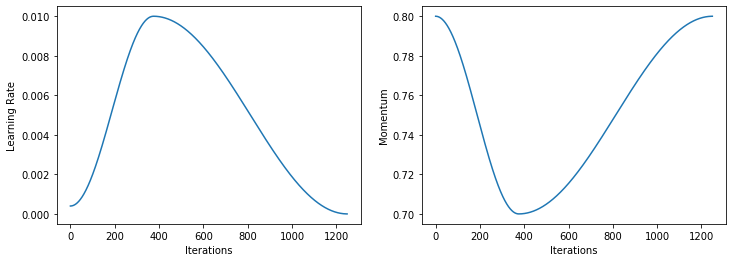

In [23]:
classifier.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


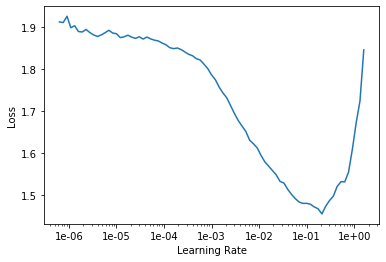

In [24]:
classifier = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')
classifier.lr_find()
classifier.recorder.plot()

In [25]:
classifier.freeze_to(-1)
classifier.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.987648,0.879144,0.623100,06:31


In [26]:
classifier.unfreeze()
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-4, 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.923519,0.822100,0.642800,07:37


In [27]:
classifier.unfreeze()
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(1e-5, 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.857015,0.807079,0.649300,11:21


In [28]:
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(1e-4/100., 1e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.852648,0.799936,0.652600,14:49


### Section 4 - Results 

In [0]:
preds, y, losses = classifier.get_preds(with_loss=True)

In [0]:
interp = ClassificationInterpretation(losses=losses, y_true=y, preds=preds, learn=classifier)

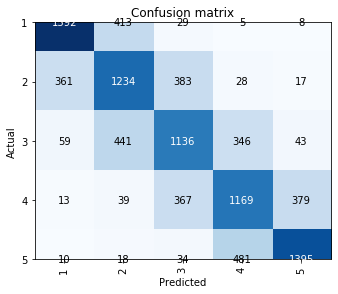

In [31]:
interp.plot_confusion_matrix()

A few sentences have been tested below 

In [37]:
rev = [
    'The pool was 10 times dirty',
    '5 stars',
    ':-(',
    'confused',
    'Loved our stay in this hotel The rooms were amazingly confortable',
    'water was cold and the room not isolated at all', 
    'could have been better',
    'Staff was amazing',
    '',
    'Staff was amazing food was bad',
    'Staff was amazing 123 :-) @super #loveit'
    'Food was great',
    'Food was not bad'
]

for s in rev:
    print(s, '\n=== Predicted:', classifier.predict(s))
    print()

The pool was 10 times dirty 
=== Predicted: (Category 2, tensor(1), tensor([0.2626, 0.3502, 0.1818, 0.1291, 0.0763]))

5 stars 
=== Predicted: (Category 3, tensor(2), tensor([0.0080, 0.1312, 0.4948, 0.2718, 0.0941]))

:-( 
=== Predicted: (Category 2, tensor(1), tensor([0.2942, 0.3959, 0.1394, 0.0817, 0.0888]))

confused 
=== Predicted: (Category 3, tensor(2), tensor([0.1919, 0.3519, 0.3736, 0.0712, 0.0114]))

Loved our stay in this hotel The rooms were amazingly confortable 
=== Predicted: (Category 5, tensor(4), tensor([0.0011, 0.0026, 0.0098, 0.1858, 0.8007]))

water was cold and the room not isolated at all 
=== Predicted: (Category 1, tensor(0), tensor([0.5890, 0.3406, 0.0651, 0.0045, 0.0008]))

could have been better 
=== Predicted: (Category 2, tensor(1), tensor([0.2776, 0.5123, 0.1386, 0.0469, 0.0246]))

Staff was amazing 
=== Predicted: (Category 5, tensor(4), tensor([0.0888, 0.2686, 0.1606, 0.1719, 0.3101]))

 
=== Predicted: (Category 2, tensor(1), tensor([0.2142, 0.4097, 0.2

The below steps are exporting and importing of the model (specific to Colab)

In [0]:
classifier.export()

In [0]:
#upload and change name of clasifier as export
from pathlib import Path

In [0]:
x = Path('.')

In [19]:
x

PosixPath('.')

In [0]:
#Reloading the classifier
classifier = load_learner(x)

In [0]:
# do not run this except if you want the predict results from the model trained on labelled data alone
#test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data.csv')

In [0]:
# do not run this except if you want the predict results from the model trained on labelled data alone
#test_sub = pd.DataFrame(test_data, columns=("test_id", "text", "label"))
#for i in range(0,len(test_sub)):
#  predict_for = test_sub.iloc[i,1]
#  test_sub.iloc[i,2] = classifier.predict(predict_for)[0]
  
  
#test_sub.to_csv('result1.csv',index=False)
#test_sub.to_csv('/content/drive/My Drive/Colab Notebooks/result2.csv',index=False)

#test_sub.head()

We can use this model to run the test data but we have beed provided with 600k unlabelled data which we can use to improve the model 

### Section 5 - Semi supervised learning 

The approach used is such that the unlabelled data is sampled in two bits and then the sampled data is used for prediction
Only the labels that are predicted with >.80 confidence are re-used to train the whole above said model again 

In [0]:
#sample 50k points and run 
unlabelled_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/unlabeled_data.csv')

In [25]:
unlabelled_data1= unlabelled_data[0:300000]
unlabelled_data2=unlabelled_data[300000:len(unlabelled_data)]

sample1=unlabelled_data1.sample(50000)
sample2=unlabelled_data2.sample(50000)


,text,label,pvalue
331937,It's New Year's Eve. Earnest has a special (an...,0,0
476678,Went with my mom for a quick lunch as we were ...,0,0
340956,"Aside from all the other reviews, this has to ...",0,0
565239,I went to the Rio Seafood Buffet last August a...,0,0
527963,Let's raise this up a star!!!\r\nMy last revie...,0,0


In [27]:
sample1_sub = sample1
sample1_sub['label']='0'
sample1_sub['pvalue']='0'
sample1_sub.head()

sample2_sub = sample2
sample2_sub['label']='0'
sample2_sub['pvalue']='0'
sample2_sub.head()

,text,label,pvalue
331937,It's New Year's Eve. Earnest has a special (an...,0,0
476678,Went with my mom for a quick lunch as we were ...,0,0
340956,"Aside from all the other reviews, this has to ...",0,0
565239,I went to the Rio Seafood Buffet last August a...,0,0
527963,Let's raise this up a star!!!\r\nMy last revie...,0,0


In [0]:

for i in range(0,len(sample1_sub)):
  for_predict = sample1_sub.iloc[i,0]
  output=classifier.predict(for_predict)
  sample1_sub.iloc[i,1] = output[0]
  sample1_sub.iloc[i,2] = max(output[2])
  
sample1_sub.to_csv('unlabeled_result1.csv',index=False)

In [0]:

for i in range(0,len(sample2_sub)):
  for_predict = sample2_sub.iloc[i,0]
  output=classifier.predict(for_predict)
  sample2_sub.iloc[i,1] = output[0]
  sample2_sub.iloc[i,2] = max(output[2])
  
sample2_sub.to_csv('unlabeled_result2.csv',index=False)

In [5]:
#sample1_sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sample1_sub.csv')
sample1_sub.head(3)

,text,label,pvalue
0,We have been going to this Chinese restaurant ...,5,"(Category 5, tensor(4), tensor([0.0069, 0.0084..."
1,"Products frequently precipitate, orders are ne...",2,"(Category 2, tensor(1), tensor([3.8954e-01, 5...."
2,I have previously purchased some baked goods f...,1,"(Category 1, tensor(0), tensor([0.7627, 0.2061..."


In [6]:
#sample2_sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sample2_sub.csv')
sample2_sub.head(3)

,text,label,pvalue
0,"Loved our lunch yesterday, but dinner was fair...",3,"(Category 3, tensor(2), tensor([0.0036, 0.1173..."
1,Honest and reliable. Never try to up sell or p...,5,"(Category 5, tensor(4), tensor([0.0761, 0.0855..."
2,Great service and great prices! Fast response...,5,"(Category 5, tensor(4), tensor([0.0070, 0.0037..."


In [66]:
l=0
for i in range(0,len(sample1_sub)):
  if (sample1_sub.iloc[i,2] >= .8):
    
    l=l+1

print(l)
  

9667


In [0]:
j=0
for i in range(0,len(sample2_sub)):
  if (sample2_sub.iloc[i,2] >= .8):
    
    j=j+1

print(j)

In [0]:
data1 = pd.DataFrame(0, index = np.arange(l) , columns=['text','label'])
data2 = pd.DataFrame(0, index = np.arange(j) , columns=['text','label'])


In [0]:
l=0
for i in range(0,len(sample1_sub)):
  
  if ((sample1_sub.iloc[i,2]) >= .80):
    data1.iloc[l,0] = sample1_sub.iloc[i,0]
    data1.iloc[l,1] = sample1_sub.iloc[i,1]
    l=l+1

In [0]:
j=0
for i in range(0,len(sample2_sub)):
  
  if ((sample2_sub.iloc[i,2]) >= .80):
    data2.iloc[j,0] = sample2_sub.iloc[i,0]
    data2.iloc[j,1] = sample2_sub.iloc[i,1]
    j=j+1
    
    

In [0]:
# Get data
sentiment_labels1 = data1['label'].value_counts().index
sentiment_count1 = data1['label'].value_counts()


In [0]:
# Get data
sentiment_labels2 = data2['label'].value_counts().index
sentiment_count2 = data2['label'].value_counts()


In [ ]:
data1.to_csv('/content/drive/My Drive/Colab Notebooks/result2.csv',index=False)
data2.to_csv('/content/drive/My Drive/Colab Notebooks/result2.csv',index=False)


We faced the issue that the predictions with sample 1 were heavily skewed to the extreme sentiments for higher confidence labels.
The second sample could give approx 10K high confidence labels that were evenly distributed for all sentiments.
This data was appened to the original labelled dataset and the a new labelled dataset of ~60K Yelp reviews was used to retrain the whole model

The appending of data was done in Excel but code has been provided as well in the below steps

The new data is named as 'updated_labeled_data' data and the model is retrained in the notebook 2


In [ ]:
updated_labeled_data = data
updated_labeled_data = updated_labeled_data.append(data2)
updated_labeled_data.to_csv('/content/drive/My Drive/Colab Notebooks/updated_labeled_data.csv',index=False)


In [0]:
##############################################################################################################################

Reference for code and explanation

https://www.kaggle.com/heisenbad/sentiment-analysis-with-transfer-learning

https://docs.fast.ai/basic_train.html

https://arxiv.org/pdf/1801.06146.pdf

    